In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import autograd
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
import math

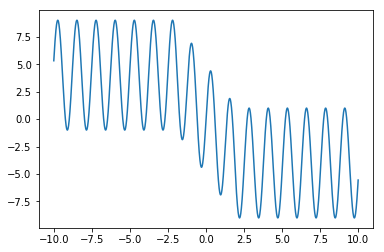

In [2]:
#построение графика функции
func = lambda x: abs(x-2) - abs(x+2) + 5*np.sin(5*x)
# dx Шаг между точками
dx = 0.01
xlist = np.arange(start = -10, stop = 10, step = dx)
ylist = [func(x) for x in xlist]
plt.plot(xlist, ylist)
plt.savefig('ini_func.png', bbox_inches='tight')

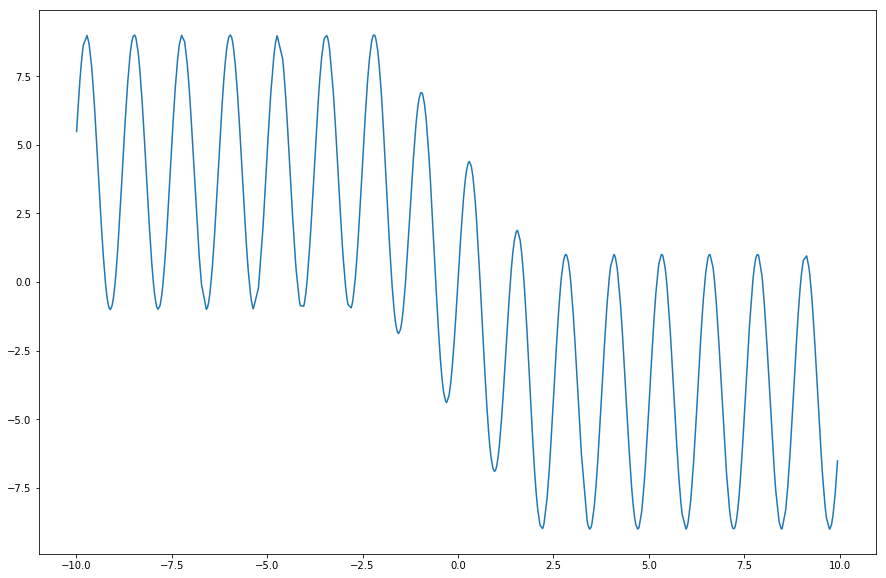

In [3]:
#Формирование исходных данных
#рандомно выберем точки на оси Х
X_data = 20 * (np.random.random(800) - 0.5)
X_data.sort()
Y_data = [func(x) for x in X_data]
data = np.array(list(zip(X_data, Y_data)))

plt.figure(figsize=(15,10))
plt.plot(data[:, 0], data[:, 1])

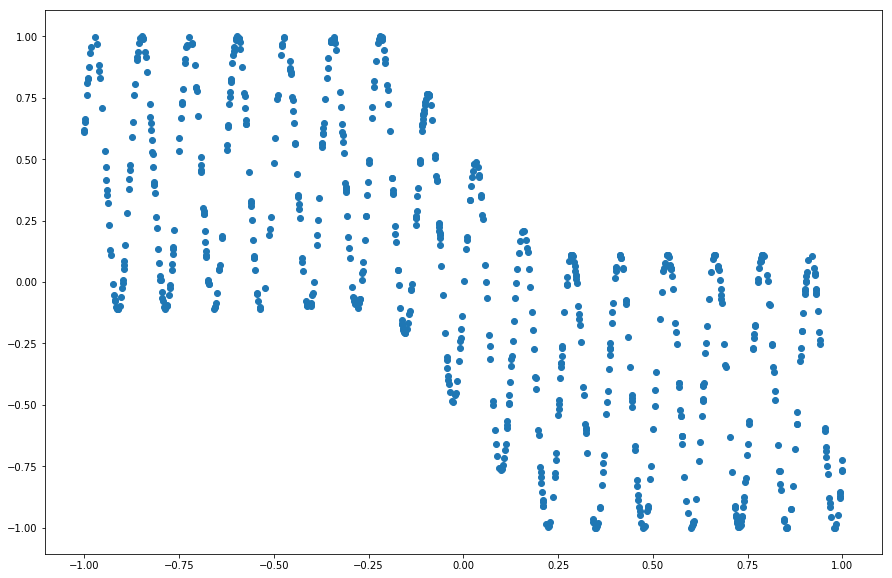

In [4]:
# Преобразование данных
data = preprocessing.minmax_scale(data, feature_range=(-1,1))

plt.figure(figsize=(15,10))
plt.scatter(data[:, 0], data[:, 1])

In [5]:
#премешать
np.random.shuffle(data)
print(data[:5])

[[ 0.68130052 -0.08345803]
 [ 0.90036204 -0.05034687]
 [-0.87892079  0.47413956]
 [-0.28827838 -0.07789272]
 [-0.57287818  0.65978189]]



 480 240 80


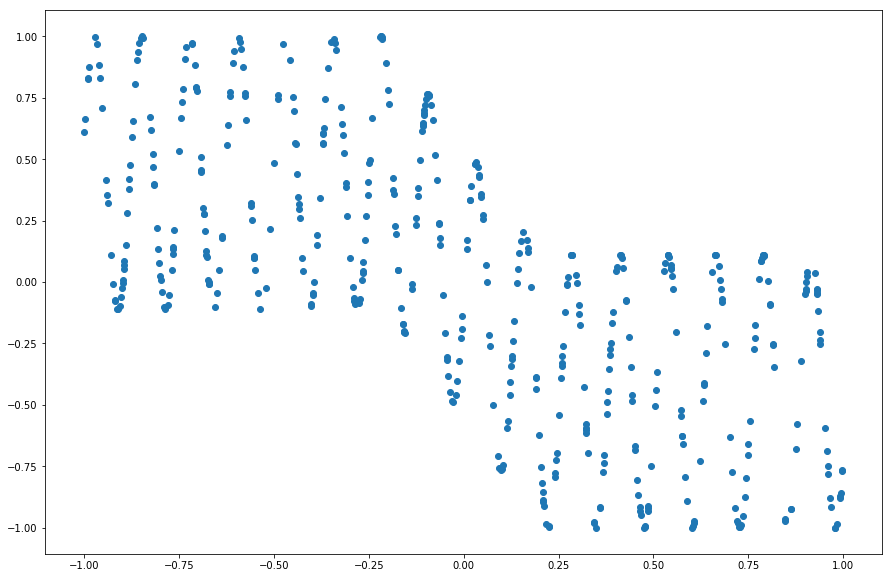

In [6]:
#отметим границы
train_border = [0, int(len(data)*0.6)]
valid_border = [int(len(data)*0.6), int(len(data)*0.9)]
test_border = [int(len(data)*0.9), len(data)]

#делим 
learn_data = data[train_border[0]: train_border[1]]
valid_data = data[valid_border[0]: valid_border[1]]
test_data = data[test_border[0]: test_border[1]]

print('\n', len(learn_data), len(valid_data), len(test_data))
plt.figure(figsize=(15, 10))
plt.scatter(learn_data[:, 0], learn_data[:, 1])


In [7]:
class SinDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    

In [8]:
dataset = SinDataset(learn_data)
dataloader = DataLoader(dataset, batch_size=50, shuffle=False)

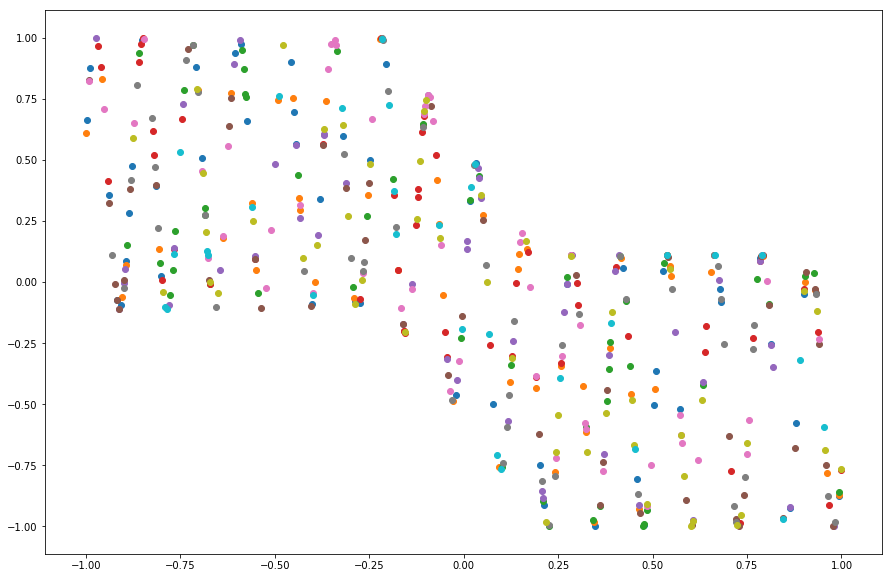

In [9]:
plt.figure(figsize=(15, 10))
for i in dataloader:
    plt.scatter(i[:, 0], i[:, 1])

In [10]:
class MainNet(nn.Module):
    def __init__(self):
        super(MainNet, self).__init__()
        self.lin1 = nn.Linear(1, 10)
        self.lin2 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = self.lin1(x)
        x = F.tanh(x)
        x = self.lin2(x)
        x = F.tanh(x)
        return x

In [11]:
net = MainNet()
net

MainNet(
  (lin1): Linear(in_features=1, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=1, bias=True)
)

In [12]:
print(type(net.lin1.weight))
net.lin1.weight.data.t()

<class 'torch.nn.parameter.Parameter'>


tensor([[ 0.9272,  0.6357, -0.6817, -0.9732,  0.9771, -0.0749, -0.0186,
         -0.0094, -0.9694,  0.2560]])

In [13]:
stds = [math.sqrt(2/12), math.sqrt(2/12)]
stds.reverse()
def init_weights(layer):
    if (type(layer) == nn.Linear):
        layer.weight.data = torch.randn(layer.weight.data.shape)*stds.pop()
        
net.apply(init_weights)

MainNet(
  (lin1): Linear(in_features=1, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=1, bias=True)
)

In [14]:
print(type(net.lin1.weight))
net.lin1.weight.data.t()

<class 'torch.nn.parameter.Parameter'>


tensor([[-0.4467,  0.1968, -0.2773,  0.4903, -0.8841,  0.2694, -0.0932,
          0.0087,  0.4068, -0.5117]])

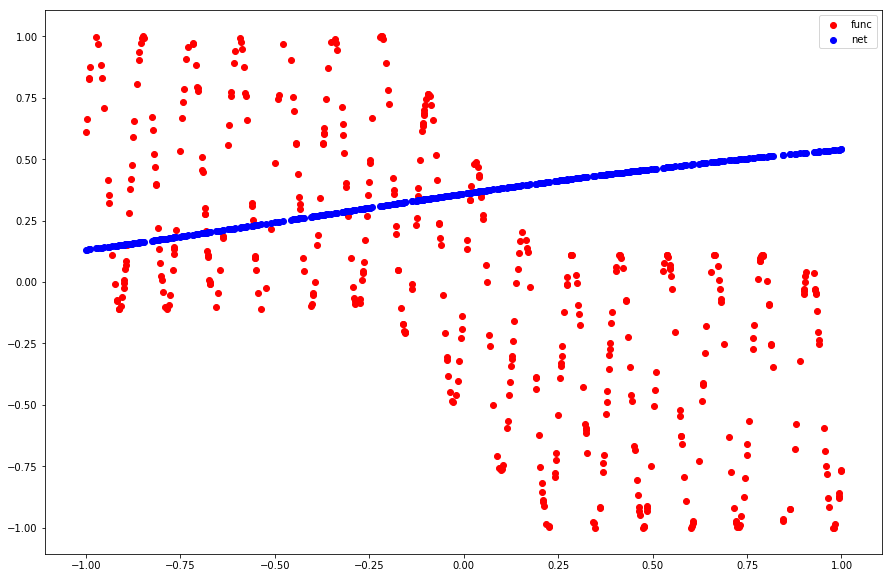

In [15]:
plt.figure(figsize=(15,10))
plt.scatter(learn_data[:, 0], learn_data[:, 1], c='r', label='func')

inputs = autograd.Variable((torch.from_numpy(learn_data[:, 0]).float()).unsqueeze(1))
predict = net.forward(inputs).data.numpy()
plt.scatter(learn_data[:, 0], predict, c='b', label='net')
plt.legend()
plt.savefig('before_training.png', bbox_inches='tight')

In [16]:
criterion = nn.MSELoss(size_average=True)
optimizer = optim.SGD(net.parameters(), lr=0.0001)

In [18]:
l1w = []
l2w = []
l1b = []
l2b = []
num_epoh = []
loss_epoh = []
valid_loss_epoh = []
test_loss_epoh = []
for epoh in range(50000):
    if epoh % 1000 == 0:
        print("epoh", epoh)
    loss_acc = 0
    for mini_batch in dataloader:
        optimizer.zero_grad()
        
        learn_inputs = autograd.Variable(mini_batch[:, 0].float()).unsqueeze(1)
        learn_labels = autograd.Variable(mini_batch[:, 1].float()).unsqueeze(1)
        
        learn_output = net(learn_inputs)
        loss = criterion(learn_output, learn_labels)
        loss.backward()
        optimizer.step()
        loss_acc += loss.data[0]
    loss_epoh.append(loss_acc / (len(learn_data) / 50))
    
    if epoh % 1000 == 0:
        num_epoh.append(epoh)
        valid_inputs = autograd.Variable(torch.from_numpy(valid_data[:, 0]).float()).unsqueeze(1)
        valid_labels = autograd.Variable(torch.from_numpy(valid_data[:, 1]).float()).unsqueeze(1)
        test_inputs = autograd.Variable(torch.from_numpy(test_data[:, 0]).float()).unsqueeze(1)
        test_labels = autograd.Variable(torch.from_numpy(test_data[:, 1]).float()).unsqueeze(1)
        valid_output = net(valid_inputs)
        valid_loss = criterion(valid_output, valid_labels)
        test_output = net(test_inputs)
        test_loss = criterion(test_output, test_labels)
        valid_loss_epoh.append(float(valid_loss.data))
        test_loss_epoh.append(float(test_loss.data))
        for num, i in enumerate(net.parameters()):
            if num == 0:
                l1w.append(np.copy(i.data.numpy()))
            if num == 1:
                l2w.append(np.copy(i.data.numpy()))
            if num == 2:
                l1b.append(np.copy(i.data.numpy()))
            if num == 3:
                l2b.append(np.copy(i.data.numpy()))

epoh 0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoh 1000
epoh 2000
epoh 3000
epoh 4000
epoh 5000
epoh 6000
epoh 7000
epoh 8000
epoh 9000
epoh 10000
epoh 11000
epoh 12000
epoh 13000
epoh 14000
epoh 15000
epoh 16000
epoh 17000
epoh 18000
epoh 19000
epoh 20000
epoh 21000
epoh 22000
epoh 23000
epoh 24000
epoh 25000
epoh 26000
epoh 27000
epoh 28000
epoh 29000
epoh 30000
epoh 31000
epoh 32000
epoh 33000
epoh 34000
epoh 35000
epoh 36000
epoh 37000
epoh 38000
epoh 39000
epoh 40000
epoh 41000
epoh 42000
epoh 43000
epoh 44000
epoh 45000
epoh 46000
epoh 47000
epoh 48000
epoh 49000


In [19]:
l1w = np.array(l1w)
l2w = np.array(l2w)
l1b = np.array(l1b)
l2b = np.array(l2b)
l2b.shape

(50, 1)

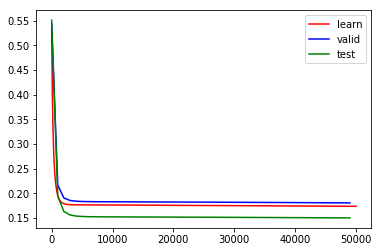

In [21]:
plt.plot(loss_epoh, color='r', label = 'learn')
plt.plot(num_epoh, valid_loss_epoh, color='b', label = 'valid')
plt.plot(num_epoh, test_loss_epoh, color='g', label = 'test')
plt.legend()
plt.savefig('train_valid_test.png', bbox_inches='tight')

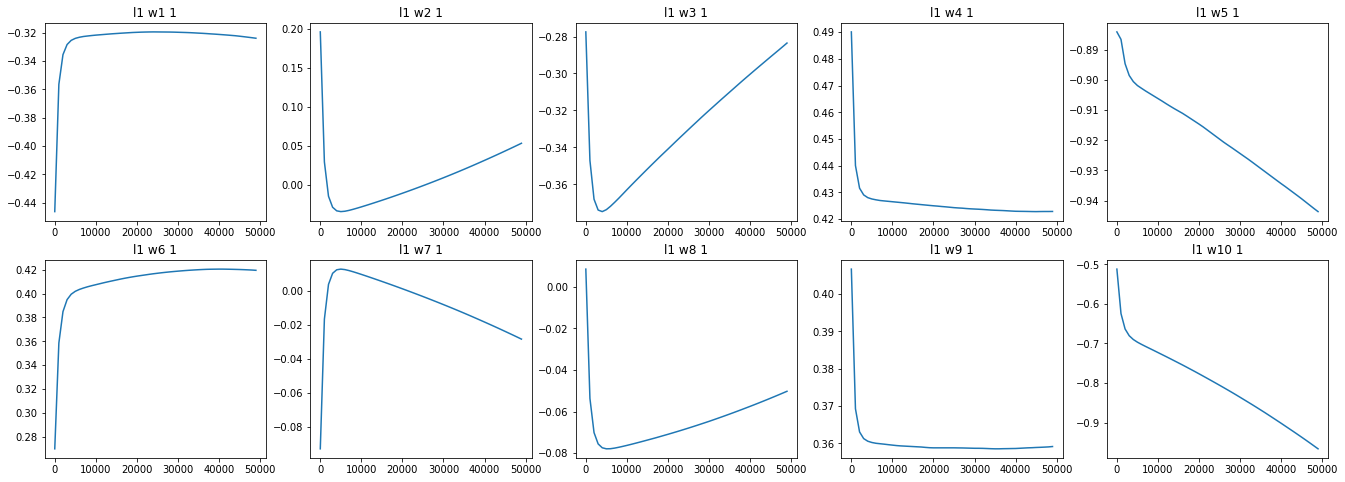

In [28]:
plt.figure(figsize=(23,8))
for i in range(10):
    plt.subplot(2, 5, 1 + i )
    plt.plot(num_epoh, l1w[:, i, 0])
    plt.title('l1 w' + str(i+1)+' 1')
plt.savefig('l1w.png', bbox_inches='tight')

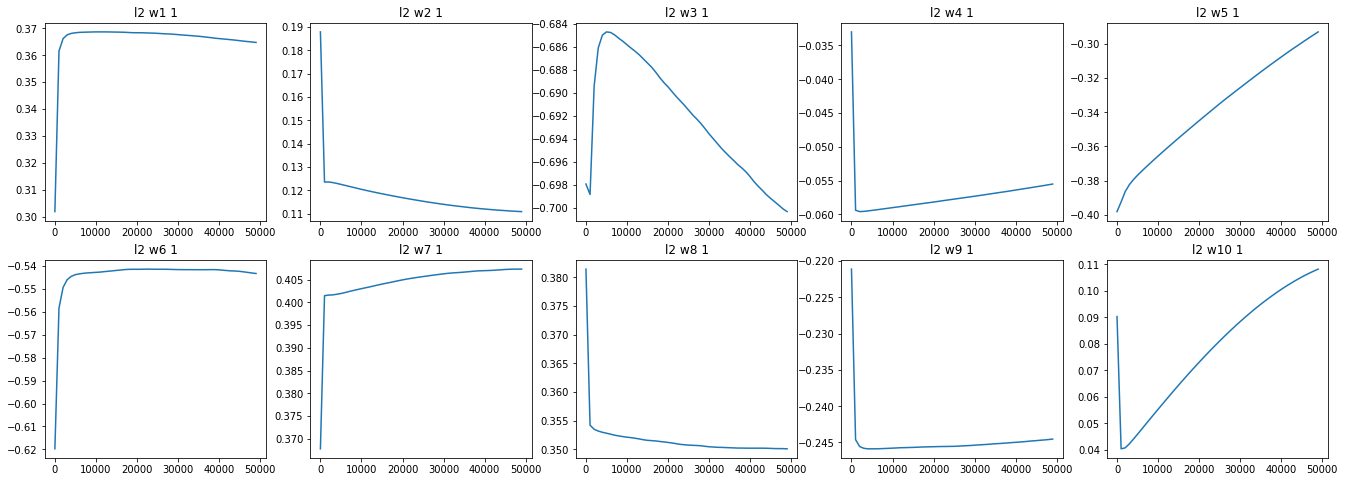

In [29]:
plt.figure(figsize=(23,8))
for i in range(10):
    plt.subplot(2, 5, 1 + i )
    plt.plot(num_epoh, l2w[:, i])
    plt.title('l2 w' + str(i+1)+' 1')
plt.savefig('l2w.png', bbox_inches='tight')

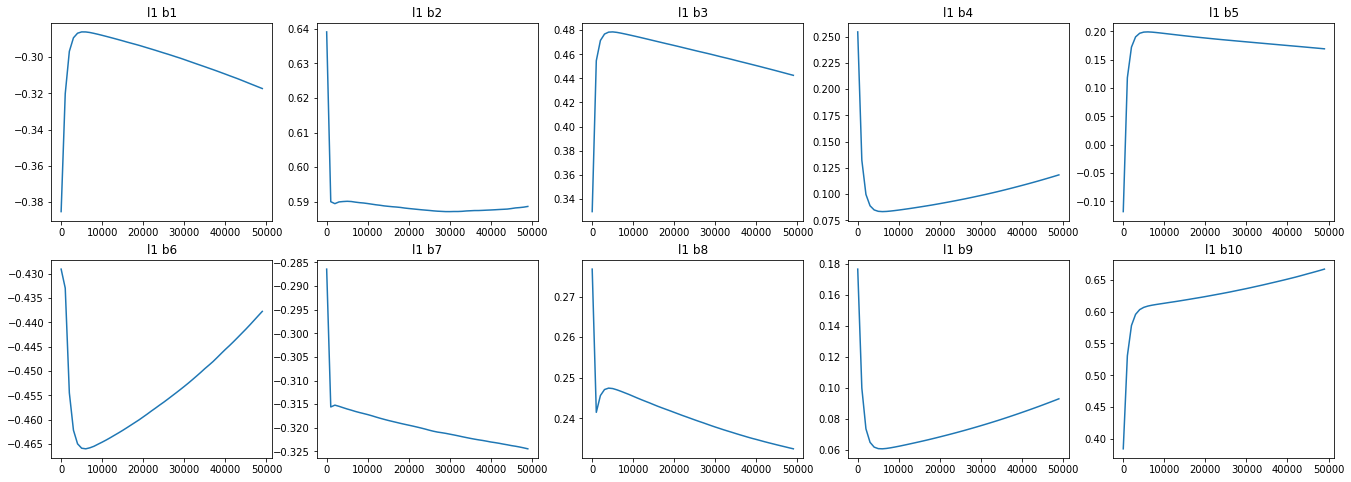

In [30]:
plt.figure(figsize=(23,8))
for i in range(10):
    plt.subplot(2, 5, 1 + i )
    plt.plot(num_epoh, l1b[:, 0, i])
    plt.title('l1 b' + str(i+1))
plt.savefig('l1b.png', bbox_inches='tight')

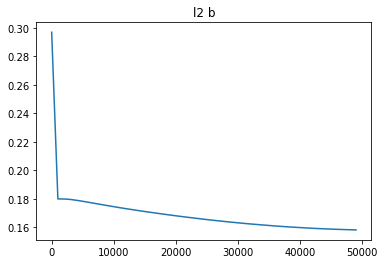

In [31]:
plt.plot(num_epoh, l2b[:, 0])
plt.title('l2 b')
plt.savefig('l2b.png', bbox_inches='tight')

In [32]:
print("learn:")
print(max(loss_epoh))
print(math.sqrt(np.var(loss_epoh)))
print(math.sqrt(np.mean(loss_epoh)))

print("valid:")
print(max(valid_loss_epoh))
print(math.sqrt(np.var(valid_loss_epoh)))
print(math.sqrt(np.mean(valid_loss_epoh)))

print("test:")
print(max(test_loss_epoh))
print(math.sqrt(np.var(test_loss_epoh)))
print(math.sqrt(np.mean(test_loss_epoh)))

learn:
tensor(0.5319)
0.018704328569369006
0.4212334487844294
valid:
0.5442165732383728
0.05084593581355371
0.4359424101987108
test:
0.551145076751709
0.05615327305490825
0.40060818302130907


[-0.56624925] [0.5577296]


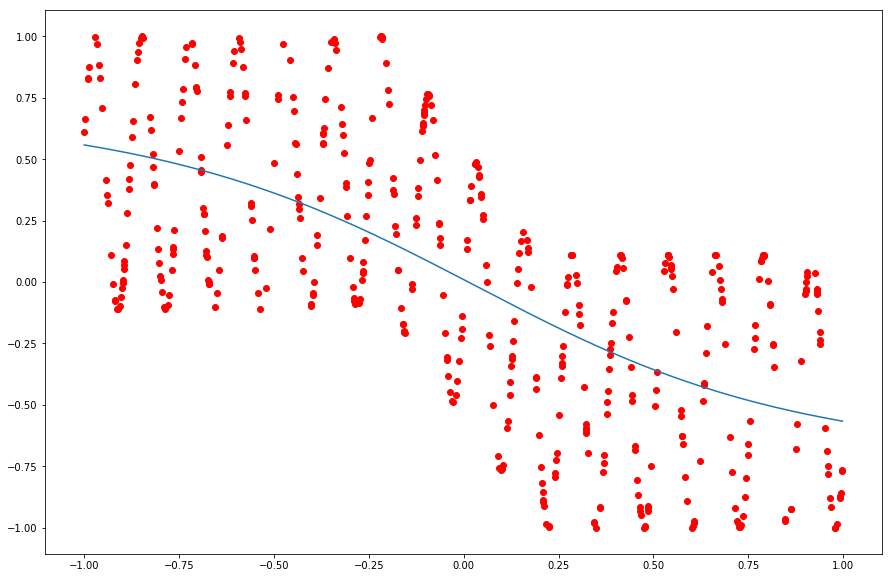

In [33]:
df_buf = pd.DataFrame(dataset.data)
df_buf = df_buf.sort_values(by=0)

x = autograd.Variable((torch.from_numpy(df_buf.get_values()[:, 0]).float()).unsqueeze(1))
y = net.forward(x)
x = x.data.numpy()
y = y.data.numpy()
print(min(y), max(y))
plt.figure(figsize=(15,10))
plt.scatter(learn_data[:,0], learn_data[:,1], color='r')
plt.plot(x, y)
plt.savefig('learndot.png', bbox_inches='tight')

In [34]:
plt.plot(df_buf[:, 0], net.tanh1.fx[:, 0].data.numpy())
plt.savefig('yk_before_training.png', bbox_inches='tight')

TypeError: unhashable type: 'slice'